# Pre-Processing of Bank Dataset


In [1]:
# Environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pathlib import Path

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    average_precision_score
)

In [2]:
# install custom library
try: 
    # check if jcds is installed
    from jcds import reports as jrep
except ImportError: 
    print("Installing custom library: jcds")
    !pip install git+https://github.com/junclemente/jcds.git


from jcds import reports as jrep
from jcds import eda as jeda 


In [3]:
# Retrieve dataset
# Code developed with assistance from Generative AI

# check development environment
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# connect to drive if IN_COLAB = True
if IN_COLAB:
    from google.colab import drive 
    drive.mount('/content/drive')

# set datapath
data_path = "../datasets/bank-additional-full.csv"

# download dataset if IN_COLAB = True
if IN_COLAB: 
    print("Running in Colab... downloading dataset.")
    data_url = "https://raw.githubusercontent.com/junclemente/ads504-final_project/main/datasets/bank-additional-full.csv"
    if not os.path.exists("../datasets"):
        os.makedirs("../datasets")
    if not os.path.exists(data_path):
        !wget -q {data_url} -O {data_path}
else: 
    print("Running locally... using local dataset.")

# Load the dataset
df = pd.read_csv(data_path, sep=";")
df.head()

Running locally... using local dataset.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Numerical Features


### Cardinality Report

In [4]:
jrep.data_cardinality(df, show_columns=True)

CARDINALITY REPORT

Total columns analyzed: 21

[BINARY COLUMNS]
There are 2 binary columns.
 * Columns: ['contact', 'y']
There are 0 binary with nan.

[CONSTANT/NEAR CONSTANT COLUMNS]
There are 0 constant columns.
There are 1 near-constant columns with >= 95% of values being the same.
 * Columns: ['pdays']

[LOW CARDINALITY CATEGORICAL COLUMNS]
 * There are 10 low cardinality columns with <= 10 unique values.
Columns:
 * marital: 4 unique values
 * education: 8 unique values
 * default: 3 unique values
 * housing: 3 unique values
 * loan: 3 unique values
 * contact: 2 unique values
 * month: 10 unique values
 * day_of_week: 5 unique values
 * poutcome: 3 unique values
 * y: 2 unique values

[HIGH CARDINALITY CATEGORICAL COLUMNS]
 * There are 0 high cardinality variables with >=90% unique values.


### Outliers

In [5]:
# get total count of outliers
outliers = jeda.detect_outliers_iqr(df)

# create dataframe
outliers_df = pd.DataFrame(list(outliers.items()), columns=["feature", "count"])
display(outliers_df)

,feature,count
0,age,469
1,duration,2963
2,campaign,2406
3,pdays,1515
4,previous,5625
5,emp.var.rate,0
6,cons.price.idx,0
7,cons.conf.idx,447
8,euribor3m,0
9,nr.employed,0


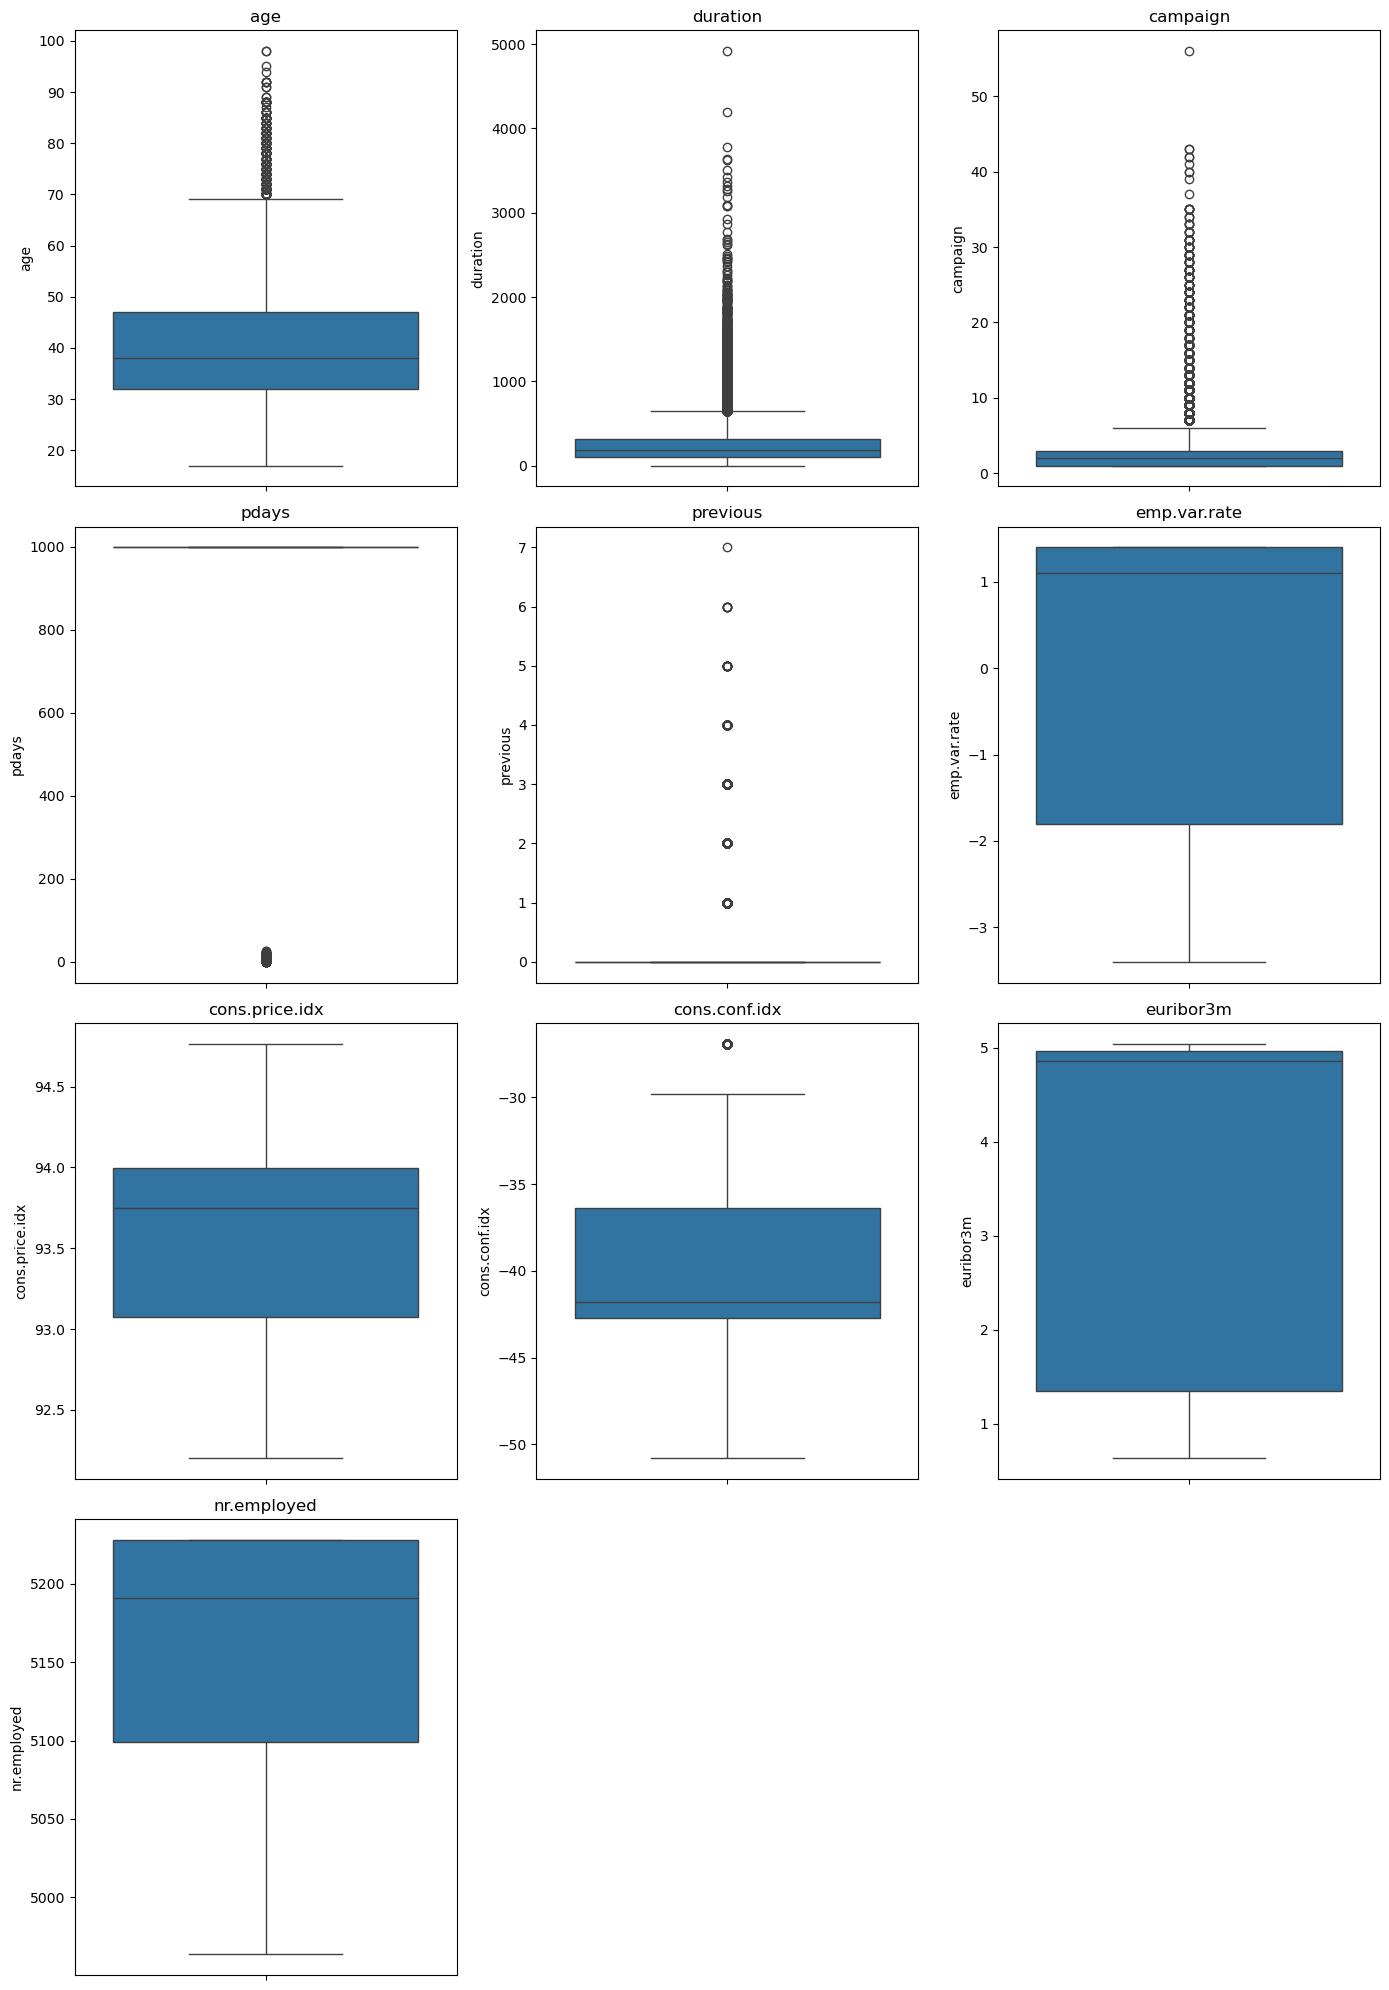

In [6]:
jeda.plot_outlier_boxplots(df)

### Observation


Six of the numerical variables have outliers.

1. **age outliers:** 70 - 100. These appear to be legitimate ages. No processing needed, maybe center/scale transform.
2. **duration:** based on data dictionary, this feature is highly correlated with target and should be removed.
3. **campaign:** There are 2406 detected outlies and showing a right skew. Transform to center/scale should be considered.
4. **pdays:** This could be converted to binary.
5. **previous:** Represents the number of times a customer was contacted prior to the campaign. This could be converted to binary: contacted vs not contacted.
6. **cons.conf.idx:** Total 447 outliers detected. Based on distribution from EDA, maybe this can be binned or turned to categorical.

Possible multicolinearity:

- euribor3m and emp.var.rate
- nr.employed and emp.var.rate

- cons.price.idx and emp.var.rate

- pdays and previous


## Categorical Features


### Observations

- marital: does not show much variability; may not be a good predictor
- housing: does not show much variability; not a good predictor unless `unknown` could have information
- loan: same as housing, does not show much variability. Also has a `unknown`
- day_of_week: does not show much variability; may not be a good predictor

Based on chi_2 stat, `housing` and `loan` are not statistically significant with p-value > 0.05.


With the Cramer's V statistic, `marital` and `day_of_week` do not show strong association with the target, `0.5`, and `0.3` respectively. These may not be good predictors and could be candidates for removal from the final dataset for modeling.


## Variables to Drop

Due to multicollinearity with `emp.var.rate`, the following numerical features will be dropped:

- euribor3m
- nr.employed
- cons.price.idx

_Out of these four numerical features, without someone with domain knowledge, generative AI was asked which feature would be best to keep. ChatGPT recommended keeping `emp.var.rate` due to "strong economic indicator, lower redundancy, and most interpretable."_

`pdays` and `previous` also show colinearity. Consder converting `pdays` to binary and dropping `previous` as it is not a strong predictor of the target.

Due to low statistical significance and low strength of association, the following categorical features will be dropped:

- housing
- loan


# Transformation Pipelines

In [7]:
jrep.data_info(df, show_columns=True)


SHAPE:
There are 41188 rows and 21 columns (30.26 MB).

DUPLICATES:
There are 12 duplicated rows.

COLUMNS/VARIABLES:
Column dType Summary:
 * object: 11
 * int: 5
 * float: 5
There are 10 numerical (int/float/bool) variables.
 * Columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
There are 11 categorical (nominal/ordinal) variables.
 * Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

DATETIME COLUMNS:
There are 0 datetime variables and 0 possible datetime variables.

OTHER COLUMN/VARIABLE INFO:
ID Like Columns (threshold = 95.0%): 0
Columns with mixed datatypes: 0
 * Columns: []


In [8]:
# get feature list by type
cat_var = jeda.show_catvar(df)
con_var = jeda.show_convar(df)
target = "y"

# remove target from categorical list
cat_var = [col for col in cat_var if col != target]

print(f"Categorical variables:", cat_var)
print(f"Continuous variables:", con_var)

Categorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Continuous variables: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [9]:
cols_to_drop = [
    "housing",
    "loan",
    "previous",
    "pdays",  # after converting to binary
    "euribor3m",
    "nr.employed",
    "cons.price.idx",
]

con_var = [c for c in con_var if c not in cols_to_drop]
cat_var = [c for c in cat_var if c not in cols_to_drop]

## Train / Test Split

In [10]:
# Encode target variable to 0, 1 prior to train_test_split
df[target] = df[target].replace({"no": 0, "yes": 1}).astype(int)
# show target unique values
jeda.list_unique_values(df, column=target)

>>> EXECUTING DataFrame["y"].unique().tolist()
Unique values in 'y':
[0, 1]


/tmp/ipykernel_102333/570709414.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[target] = df[target].replace({"no": 0, "yes": 1}).astype(int)


In [11]:
RANDOM_STATE = 42
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

## Define Pipeline Tranformeers

In [12]:
# columns to drop
def drop_cols(X):
    X = X.copy()
    return X.drop(columns=cols_to_drop)

drop_columns = FunctionTransformer(drop_cols, validate=False)

# convert pdays to binary
def pdays_to_binary(X):
    X = X.copy()
    X["pdays_binary"] = (X["pdays"] != 999).astype(int)
    return X


convert_to_binary = FunctionTransformer(pdays_to_binary, validate=False)

# scaler and encoder
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), con_var),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_var),
    ]
)

## Modeling on the Training Set

In [13]:
# define function for modeling generator
def make_pipeline(clf):
    return ImbPipeline(steps=[
        ("bin", convert_to_binary),
        ("drop", drop_columns),
        ("encoder", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("classifier", clf)
    ])

In [14]:
# initialize the models (classifiers)
models = {
    "Perceptron": Perceptron(random_state=RANDOM_STATE),
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=RANDOM_STATE, probability=True),
    "Neural Network": MLPClassifier(random_state=RANDOM_STATE, max_iter=1000),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE)
}

In [15]:
# set scoring metrics
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

In [ ]:
# cross-validate each model
# initialize results dictionary
avg_train_results = {}
full_train_results = {}
for name, clf in models.items():
    pipe = make_pipeline(clf)
    cv_results = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=4, return_train_score=True)
    full_train_results[name] = {
        "fit_time": cv_results["fit_time"],
        "score_time": cv_results["score_time"],
        "train_accuracy": cv_results["train_accuracy"],
        "train_precision": cv_results["train_precision"],
        "train_recall": cv_results["train_recall"],
        "train_f1": cv_results["train_f1"],
        "train_roc_auc": cv_results["train_roc_auc"]}
    avg_train_results[name] = {metric: np.mean(cv_results[f"train_{metric}"]) for metric in scoring}
    avg_train_results[name].update({f"std_{metric}": np.std(cv_results[f"train_{metric}"]) for metric in scoring})

/home/junc/miniconda3/envs/ads504_project/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:42:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/junc/miniconda3/envs/ads504_project/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:42:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/junc/miniconda3/envs/ads504_project/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:42:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/junc/miniconda3/envs/ads504_pro

In [18]:
# create dataframe of average results
avg_train_results_df = pd.DataFrame(avg_train_results).T
# round results to 3 decimal places
avg_train_results_df = avg_train_results_df.round(3)
# display average results
display(avg_train_results_df)

,accuracy,precision,recall,f1,roc_auc,std_accuracy,std_precision,std_recall,std_f1,std_roc_auc
Perceptron,0.815,0.356,0.757,0.482,0.872,0.024,0.037,0.061,0.032,0.020
Logistic Regression,0.861,0.441,0.868,0.585,0.933,0.001,0.002,0.002,0.002,0.001
K-Nearest Neighbors,0.901,0.533,0.998,0.695,0.997,0.001,0.003,0.001,0.003,0.000
Support Vector Machine,0.897,0.525,0.934,0.672,0.962,0.001,0.004,0.001,0.003,0.001
Neural Network,0.975,0.849,0.941,0.893,0.994,0.004,0.022,0.006,0.014,0.001
XGBoost,0.937,0.729,0.696,0.712,0.967,0.001,0.006,0.008,0.006,0.001
AdaBoost,0.878,0.476,0.807,0.599,0.929,0.002,0.006,0.011,0.005,0.002
Random Forest,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000


## Out of Sample Validation Testing

In [19]:
# initialize test metrics and predictions 
metrics = []
preds = {}   # preds[name] = (y_test, y_pred, y_proba)

for name, clf in models.items():
    pipe = make_pipeline(clf)
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    # try proba or decision_function
    if hasattr(pipe, 'predict_proba'):
        y_score = pipe.predict_proba(X_test)[:,1]
    else:
        y_score = pipe.decision_function(X_test)

    metrics.append({
        'model':   name,
        'accuracy':   accuracy_score(y_test,  y_pred),
        'precision':  precision_score(y_test, y_pred),
        'recall':     recall_score(y_test,    y_pred),
        'f1':         f1_score(y_test,       y_pred),
        'roc_auc':    roc_auc_score(y_test,  y_score)
    })
    preds[name] = (y_test, y_pred, y_score)

test_df = pd.DataFrame(metrics).set_index('model').round(3)
display(test_df)

/home/junc/miniconda3/envs/ads504_project/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:49:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,accuracy,precision,recall,f1,roc_auc
model,,,,,
Perceptron,0.849,0.404,0.721,0.518,0.892
Logistic Regression,0.866,0.452,0.899,0.602,0.940
K-Nearest Neighbors,0.862,0.439,0.820,0.572,0.889
Support Vector Machine,0.881,0.483,0.871,0.622,0.943
Neural Network,0.892,0.519,0.558,0.538,0.911
XGBoost,0.916,0.631,0.616,0.624,0.949
AdaBoost,0.884,0.491,0.815,0.613,0.934
Random Forest,0.913,0.607,0.652,0.629,0.944


### Modeling Performance Visualizations

#### Confusion Matrices

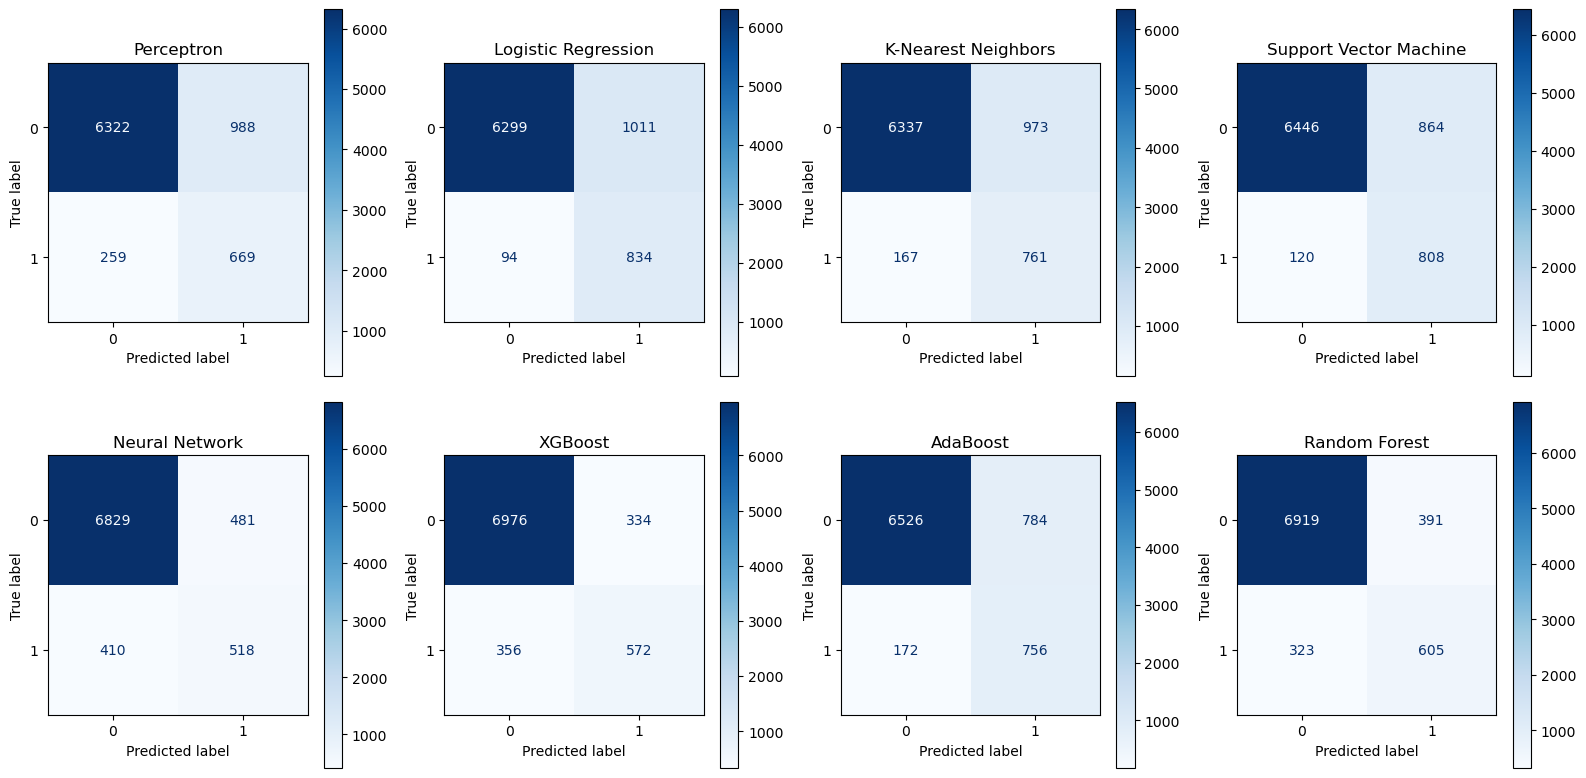

In [20]:
# preds[name] == (y_true, y_pred, y_score)
model_names = list(preds.keys())
n_models   = len(model_names)

# choose grid size
n_cols = 4
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()

for ax, name in zip(axes, model_names):
    y_true, y_pred, _ = preds[name]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(name)
    
# hide any unused subplots
for ax in axes[n_models:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

#### ROC-AUC Chart

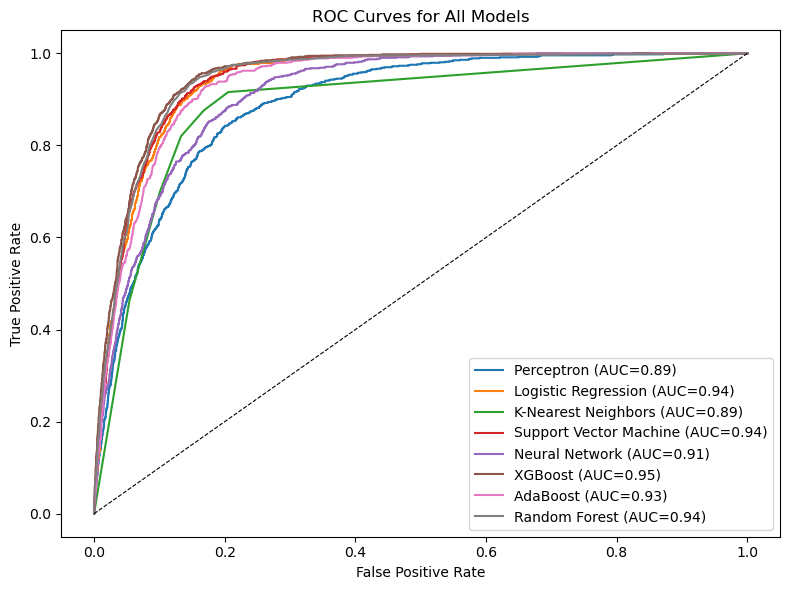

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
for name, (y_t, _, y_score) in preds.items():
    fpr, tpr, _ = roc_curve(y_t, y_score)
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_t, y_score):.2f})")

ax.plot([0,1], [0,1], 'k--', linewidth=0.8)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves for All Models")
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### Precision Recall Curves

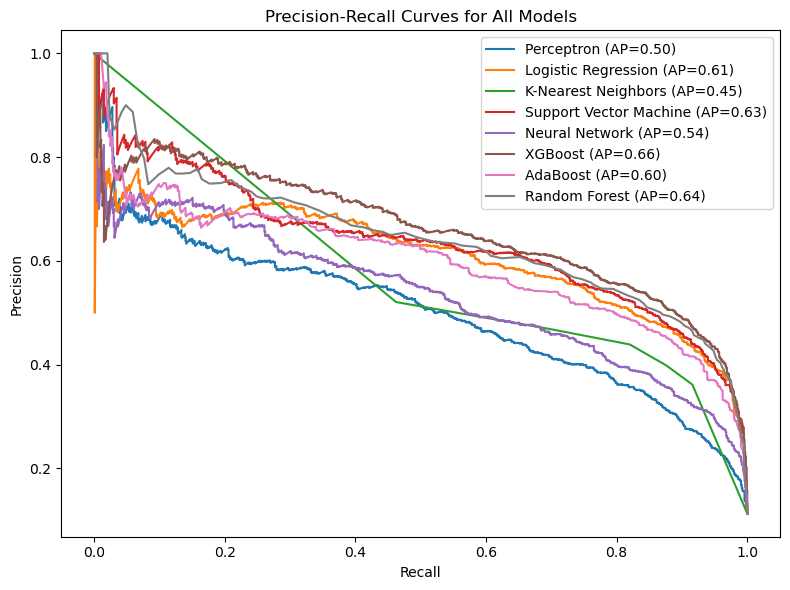

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
for name, (y_t, _, y_score) in preds.items():
    precision, recall, _ = precision_recall_curve(y_t, y_score)
    ap = average_precision_score(y_t, y_score)
    ax.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curves for All Models")
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()